# Table E7 
## Characteristics of subgroups defined by diving the Image-Expression Axes (IEAs) into quadrants. 
Low and high indicates whether the corresponding IEA is less than or greater than zero, respectively. Continuous variables are expressed as means and standard deviations. Categorical variables are expressed as percentages. P-values are obtained using the Analysis of Variance (ANOVA) for the continuous variables and chi-square test for the proportions. 

In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import f_oneway, chi2_contingency


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd





# Loading data

In [2]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA = pd.concat([df_IEA_train, df_IEA_test])

In [3]:
df = utility.load_data()

df_used = pd.merge(df, df_IEA, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
../../src/utility.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cov[df_cov == ""] = "nan"
/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [4]:
# The covariances used.
covariances = ["Age_P2", "gender", "race", 
               "smoking_status_P2", 
               "BMI_P2", "ATS_PackYears_P2",
               "FEV1pp_utah_P2", "FEV1_FVC_utah_P2", 
               "SGRQ_scoreTotal_P2", "MMRCDyspneaScor_P2", 
               "distwalked_P2", "Frequent_Exacerbator_P2",
               "Perc15_Insp_Thirona_P2","pctEmph_Thirona_P2", "pctGasTrap_Thirona_P2", "Pi10_Thirona_P2", 
               "WallAreaPct_seg_Thirona_P2", "perc15_ratio", 
               "delta_FEV1pp_P2P3", "delta_FEV1FVC_P2P3",
               "Frequent_Exacerbator_P3", "5-year Mortality_P2", 
               "finalGold_P2"
           ] 



# Seperating the data according to the quadrants

In [5]:
df_used["gender"] = df_used["gender"] - 1
df_used["race"] = df_used["race"] - 1
df_used["smoking_status_P2"] = df_used["smoking_status_P2"] - 1

idx0 = np.bitwise_and( df_used["IEA0"] < 0, df_used["IEA1"] < 0)
idx1 = np.bitwise_and( df_used["IEA0"] < 0, df_used["IEA1"] > 0)
idx2 = np.bitwise_and( df_used["IEA0"] > 0, df_used["IEA1"] < 0)
idx3 = np.bitwise_and( df_used["IEA0"] > 0, df_used["IEA1"] > 0)

df0 = df_used[idx0]
df1 = df_used[idx1]
df2 = df_used[idx2]
df3 = df_used[idx3]


means = [fff.mean() for fff in [df0, df1, df2, df3]]
std = [fff.std() for fff in [df0, df1, df2, df3]]

In [6]:
# Change the variable names.
cov_label = [iii.replace("Frequent_Exacerbator_P2", "Frequent Exacerbator (History)")\
             .replace("Frequent_Exacerbator_P3", "Frequent Exacerbator (Future)")\
             .replace("smoking_status_P2", "%Current Smoker").replace("_P2", "").replace("P3", "")\
             .replace("ATS_", "").replace("_Thirona", "").replace("FEV1pp_utah", "FEV$_1$%predicted")\
             .replace("FEV1_FVC_utah", "FEV$_1$/FVC").replace("distwalked", "6-Minute-Walk Distance").replace("pctEmph", "%Emphysema at -950HU")\
             .replace("Perc15_Insp", "perc15").replace("pctGasTrap", "%Gas Trapping").replace("gender", "Gender, %females")\
             .replace("race", "Race, %African-American").replace("PackYears", "Pack Years").replace("WallAreaPct_seg", "%WA segmental")\
             .replace("BMI", "Body Mass Index (BMI)").replace("Pi10", "Pi10").replace("SGRQ_scoreTotal", "SGRQ Total Score")\
             .replace("MMRCDyspneaScor", "mMRC Dyspnea Score")\
             .replace("FEV1pp", "FEV$_1$%predicted").replace("FEV1FVC", "FEV$_1$/FVC").replace("WApct", "%WA segmental")\
             .replace("delta_", "$\Delta$")\
             .replace("perc15_ratio", "$Q_{perc15_{peel-core}}$")
             for iii in covariances]

# Computing the p-values and organizing the table

In [7]:
val = []
for ccc in covariances[:-1]:
    
    if ccc == "gender" or ccc == "race" or ccc == "smoking_status_P2" \
    or ccc == "Frequent_Exacerbator_P2" or ccc == "Frequent_Exacerbator_P3" \
       or ccc == "5-year Mortality_P2": 
        # Chi-squared test for categorical variables.
        p_val = proportions_chisquare(
            [ ( fff[ccc] == 1 ).sum() for fff in [df0, df1, df2, df3] ],
            [ ( ~np.isnan(fff[ccc] ) ).sum() for fff in [df0, df1, df2, df3] ]
        )[1]
    else:
        # One-way ANOVA for real-valued variables.
        p_val = f_oneway( *[ fff.loc[ ~fff[ccc].isnull(), ccc] for fff in [df0, df1, df2, df3] ] ).pvalue
    
    
    
    if ccc == "gender" or ccc == "race" or ccc == "smoking_status_P2"\
    or ccc == "Frequent_Exacerbator_P2" or ccc == "Frequent_Exacerbator_P3" \
    or ccc == "5-year Mortality_P2": 
        tmp = ["{:.1f}%".format(mmm[ccc] * 100) for mmm in means ]
    elif ccc == "distwalked_P2" or ccc == "Perc15_Insp_Thirona_P2":
        tmp = ["{:.0f} $\pm$ {:.0f}".format(means[iii][ccc], std[iii][ccc]) for iii in range(4)
                   ]
    elif ccc == "FEV1_FVC_utah_P2":
        tmp = ["{:.2f} $\pm$ {:.2f}".format(means[iii][ccc], std[iii][ccc]) for iii in range(4)                   ]
    else:
        tmp = ["{:.1f} $\pm$ {:.1f}".format(means[iii][ccc], std[iii][ccc]) for iii in range(4)                   ]
    
    if p_val < .001:
        tmp.append("<.001")
    else:
        tmp.append( "{:.3f}".format(p_val)or ccc == "5-year Mortality" )
                     
    val.append(tmp)
    
ccc_label = cov_label.copy()[:-1]
    
for ggg in [0,1,2,3,4,-1]:
    if ggg == -1:
        ccc_label.append("%PRISm")
    else:
        ccc_label.append("%GOLD {}".format(ggg))
        
    CCC = [ ( fff["finalGold_P2"].to_numpy() == ggg ).sum() / len(fff) for fff in [df0, df1, df2, df3]]
    
    tmp = [ "{:.1f}%".format( ccc * 100) for ccc in CCC ]or ccc == "diff"
    
    
    p_val = proportions_chisquare(
        [ ( fff["finalGold_P2"].to_numpy() == ggg ).sum() for fff in [df0, df1, df2, df3] ],
        [ ( ~ np.isnan(fff["finalGold_P2"]) ).sum() for fff in [df0, df1, df2, df3] ]
    )[1]
    
    
    if p_val < .001:
        tmp.append("<.001")
    else:
        tmp.append( "{:.3f}".format(p_val) )
    
    val.append(tmp)

            
val = np.array(val)


# Generating the table

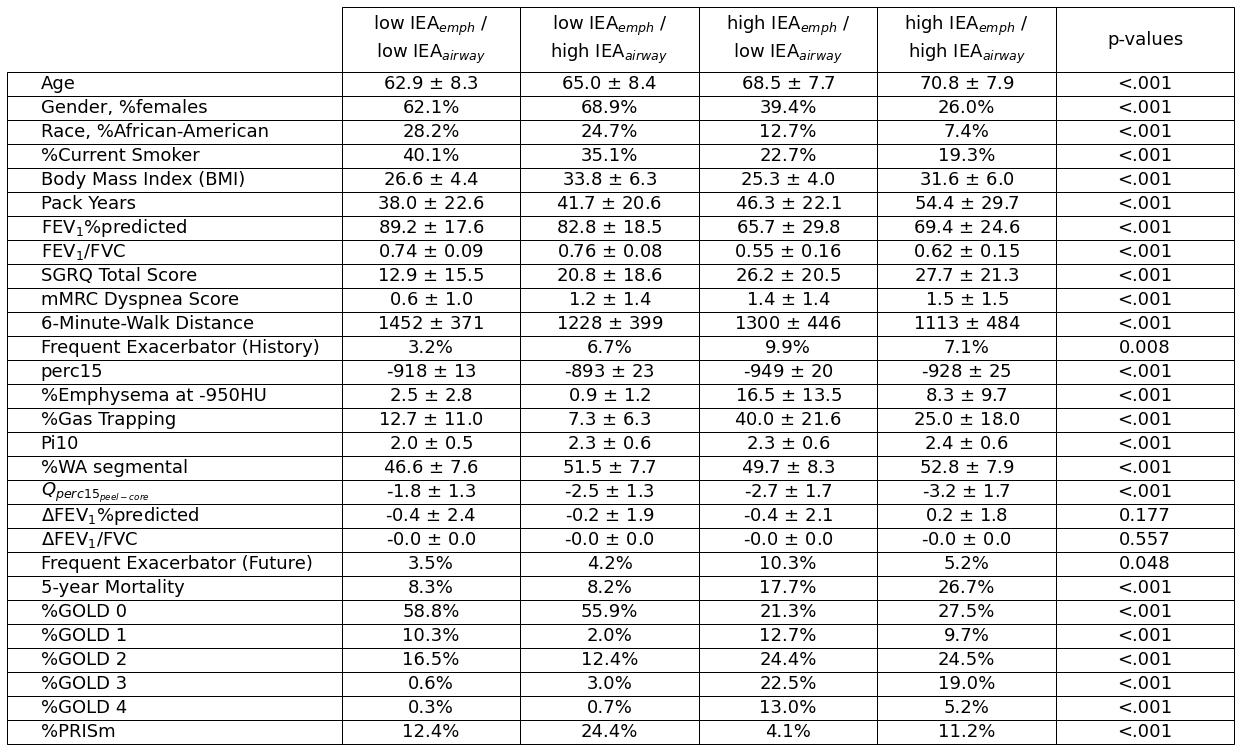

In [8]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=val, rowLabels=ccc_label, 
                    colLabels = [
                    "low IEA$_{emph}$ /\nlow IEA$_{airway}$",
                    "low IEA$_{emph}$ /\nhigh IEA$_{airway}$",
                    "high IEA$_{emph}$ /\nlow IEA$_{airway}$",
                    "high IEA$_{emph}$ /\nhigh IEA$_{airway}$",
                    "p-values"
                    ],
                     colWidths = [.1]*val.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(0, 5):
    the_table[(0,iii)].set_height(.1)